In [203]:
import pandas as pd
import ast
import os
import glob

In [204]:
import numpy as np
from scipy.stats import spearmanr
import scipy.stats as stats

def get_ranked_indices(lst, reference_list):
    return [reference_list.index(item) for item in lst]

def kendall_tau(pred, true):
    tau, p_value = stats.kendalltau(pred, true)
    return tau

def spearman_rank_correlation(pred, true):
    pred_indices = get_ranked_indices(pred, true)
    true_indices = get_ranked_indices(true, true)
    correlation, _ = spearmanr(pred_indices, true_indices)
    return correlation

def ndcg(pred, true):
    dcg = 0
    arr_len = len(pred)-1
    for i, item in enumerate(pred):
        if item in true:
            if i == 0:
                rank = true.index(item)
                dcg += (arr_len - rank)
            else:
                rank = true.index(item)
                dcg += ((arr_len-rank)) / np.log2(i + 1)
    idcg = 0
    for i, item in enumerate(true):
        if i == 0:
            idcg += (arr_len-i)
        else:
            idcg += ((arr_len-i))/ np.log2(i + 1)
    return dcg / idcg if idcg != 0 else 0

def rbo(lista, listb):
    set_a = set([])
    set_b = set([])
    overlaps = []
    for i in range(len(lista)):
        set_a.add(lista[i])
        set_b.add(listb[i])
        intersection = set_a.intersection(set_b)
        union = set_a.union(set_b)
        jaccard = len(intersection) / len(union)
        overlaps.append(jaccard)

    return np.mean(overlaps)

In [205]:
def group_and_sort(merged):
    agg_df = merged.groupby('userId').apply(
    lambda x: dict(zip(x['title'], x['predicted_rating'])), include_groups=False
    ).reset_index(name='pred_dict')

    true_df = merged.groupby('userId').apply(
        lambda x: dict(zip(x['title'], x['rating'])), include_groups=False
    ).reset_index(name='true_dict')

    merged_df = agg_df.merge(true_df, on=['userId'], how='inner')

    merged_df['pred_list'] = merged_df['pred_dict'].apply(lambda x: sorted(x, key=x.get, reverse=True))
    merged_df['true_list'] = merged_df['true_dict'].apply(lambda x: sorted(x, key=x.get, reverse=True))
    return merged_df

In [206]:
df = pd.read_csv('orig_data/all_ratings.csv')

In [207]:
csv_files = [f for f in glob.glob(os.path.join('llm_output_processed', "*.csv"))] + ['user_based/trad_user_ratings.csv']
csv_files.sort()
spearmans = []
ndcgs = []
rbos = []

for file in csv_files:
    df1 = pd.read_csv(file).dropna()
    df1.drop_duplicates(subset=['userId', 'title'], keep='first', inplace=True)
    merged = df.merge(df1, on=['userId', 'title'], how='inner')

    merged_df = group_and_sort(merged)
    merged_df['pred'] = merged_df.apply(lambda row: get_ranked_indices(row['pred_list'], row['true_list']), axis=1)
    merged_df['spearman'] = merged_df.apply(lambda x: spearman_rank_correlation(x.pred_list, x.true_list), axis=1)
    merged_df['ndcg'] = merged_df.apply(lambda x: ndcg(x.pred_list, x.true_list), axis=1)
    merged_df['kendall'] = merged_df.apply(lambda x: kendall_tau(x.pred_list, x.true_list), axis=1)
    merged_df['rbo'] = merged_df.apply(lambda x: rbo(x.pred_list, x.true_list), axis=1)

    acc_df = merged_df.drop(columns=['pred_list', 'true_list', 'pred_dict', 'true_dict', 'pred'])
    x = acc_df.mean(axis=0)
    spearmans.append(x['spearman'])
    ndcgs.append(x['ndcg'])
    rbos.append(x['rbo'])

    print(f"Results for {file}:")
    print(f"  Spearman: {x['spearman']:.4f}")
    print(f"  ndcgs: {x['ndcg']:.4f}")
    print(f"  Kendall: {x['kendall']:.4f}")
    print(f"  RBO: {x['rbo']:.4f}")
    print("-" * 40)
    merged_df.drop(columns=['pred_list', 'true_list', 'pred_dict', 'true_dict']).to_csv(f'metric_outputs/{os.path.basename(file)}_met.csv')

Results for llm_output_processed/llama70b_rp.csv:
  Spearman: 0.2412
  ndcgs: 0.8405
  Kendall: 0.0213
  RBO: 0.5303
----------------------------------------
Results for llm_output_processed/llama70b_rp_10.csv:
  Spearman: 0.2714
  ndcgs: 0.8447
  Kendall: 0.0540
  RBO: 0.5425
----------------------------------------
Results for llm_output_processed/llama70b_rp_all.csv:
  Spearman: 0.4194
  ndcgs: 0.8775
  Kendall: 0.0981
  RBO: 0.5951
----------------------------------------
Results for llm_output_processed/qwen_rp.csv:
  Spearman: 0.2532
  ndcgs: 0.8432
  Kendall: 0.0364
  RBO: 0.5391
----------------------------------------
Results for llm_output_processed/qwen_rp_10.csv:
  Spearman: 0.2626
  ndcgs: 0.8427
  Kendall: 0.0501
  RBO: 0.5460
----------------------------------------
Results for llm_output_processed/qwen_rp_all.csv:
  Spearman: 0.3595
  ndcgs: 0.8594
  Kendall: 0.0618
  RBO: 0.5908
----------------------------------------
Results for user_based/trad_user_ratings.csv:
  Sp

Checking the metrics

testing

In [208]:
df1.head()

,userId,title,predicted_rating
0,1,JFK (1991),3.534418
1,1,"Game, The (1997)",3.652169
2,1,"Mummy, The (1999)",3.139189
3,1,Tron (1982),3.326267
4,1,Pete's Dragon (1977),2.774591


In [209]:
df

,userId,rating,title
0,1,4.0,Toy Story (1995)
1,1,4.0,Grumpier Old Men (1995)
2,1,4.0,Heat (1995)
3,1,5.0,Seven (a.k.a. Se7en) (1995)
4,1,5.0,"Usual Suspects, The (1995)"
...,...,...,...
100831,610,4.0,Split (2017)
100832,610,5.0,John Wick: Chapter Two (2017)
100833,610,5.0,Get Out (2017)
100834,610,5.0,Logan (2017)


In [210]:
df2 = df.copy()
df2.rename(columns={'rating':'predicted_rating'}, inplace=True)
df2.head()

,userId,predicted_rating,title
0,1,4.0,Toy Story (1995)
1,1,4.0,Grumpier Old Men (1995)
2,1,4.0,Heat (1995)
3,1,5.0,Seven (a.k.a. Se7en) (1995)
4,1,5.0,"Usual Suspects, The (1995)"


In [211]:
merged = df.merge(df2, on=['userId', 'title'], how='inner')
merged_df = group_and_sort(merged)

In [212]:
import random

merged_df['pred_list'] = merged_df['pred_list'].apply(lambda x: random.shuffle(x) or x)

In [213]:
merged_df['pred'] = merged_df.apply(lambda row: get_ranked_indices(row['pred_list'], row['true_list']), axis=1)
merged_df['spearman'] = merged_df.apply(lambda x: spearman_rank_correlation(x.pred_list, x.true_list), axis=1)
merged_df['ndcg'] = merged_df.apply(lambda x: ndcg(x.pred_list, x.true_list), axis=1)
merged_df['kendall'] = merged_df.apply(lambda x: kendall_tau(x.pred_list, x.true_list), axis=1)
merged_df['rbo'] = merged_df.apply(lambda x: rbo(x.pred_list, x.true_list), axis=1)

acc_df = merged_df.drop(columns=['pred_list', 'true_list', 'pred_dict', 'true_dict', 'pred'])
x = acc_df.mean(axis=0)
spearmans.append(x['spearman'])
ndcgs.append(x['ndcg'])
rbos.append(x['rbo'])

print(f"Results for {file}:")
print(f"  Spearman: {x['spearman']:.4f}")
print(f"  ndcgs: {x['ndcg']:.4f}")
print(f"  Kendall: {x['kendall']:.4f}")
print(f"  RBO: {x['rbo']:.4f}")
print("-" * 40)
merged_df.drop(columns=['pred_list', 'true_list', 'pred_dict', 'true_dict']).to_csv(f'metric_outputs/{os.path.basename(file)}_met.csv')

Results for user_based/trad_user_ratings.csv:
  Spearman: -0.0007
  ndcgs: 0.8224
  Kendall: 0.0012
  RBO: 0.3971
----------------------------------------


n-shot all aligned


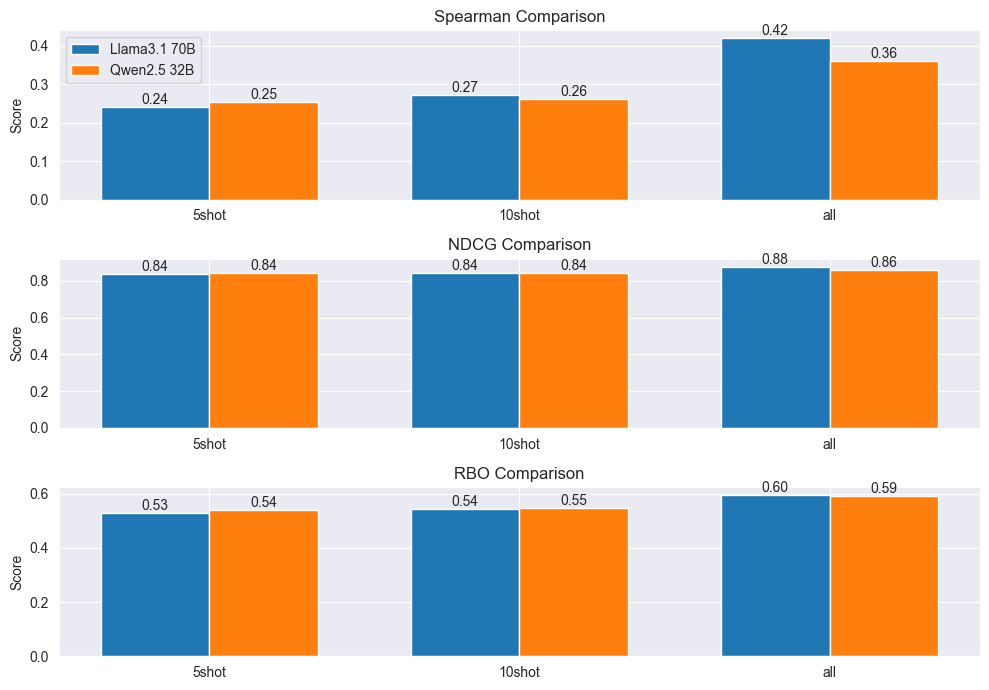

In [235]:
import matplotlib.pyplot as plt

models = [x.split('/')[1].split('.')[0] for x in csv_files]
models.append('Random')

data = {
    'models': models,
    'spearmans': spearmans,
    'ndcgs': ndcgs,
    'rbos': rbos
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df['models'] = df['models'].apply(lambda x: x.replace('_rp', '').strip())
df.rename(columns={'spearmans': 'Spearman', 'ndcgs': 'NDCG', 'rbos': 'RBO'}, inplace=True)
df.set_index('models', inplace=True)
# Set 'run_name' as the index

# Plot settings
metrics = ['Spearman', 'NDCG', 'RBO']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for the base and llama8

# Create a plot for each metric
fig, axs = plt.subplots(3, figsize=(10, 7))

for i, metric in enumerate(metrics):
    ax = axs[i]
    base_values = df.loc[['llama70b', 'llama70b_10', 'llama70b_all'], metric].values
    llama8_values = df.loc[['qwen', 'qwen_10', 'qwen_all'], metric].values

    # Bar positions
    bar_width = 0.35
    base_positions = [0, 1, 2]
    llama8_positions = [pos + bar_width for pos in base_positions]
    # llama8_positions = [1, 3]

    # Plot bars
    all_bars = []
    all_bars.append(ax.bar(base_positions, base_values, color=colors[0], width=bar_width, label='Llama3.1 70B'))
    all_bars.append(ax.bar(llama8_positions, llama8_values, color=colors[1], width=bar_width, label='Qwen2.5 32B'))
    for bars in all_bars:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    # Set x-ticks and labels
    ax.set_xticks([pos+(bar_width/2) for pos in base_positions])
    ax.set_xticklabels(['5shot', '10shot', 'all'])

    # Set title and labels
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel('Score')
    if i == 0:
        ax.legend(loc='upper left')
    # ax.legend()

# Adjust layout
plt.tight_layout()
plt.savefig('QwenVsLlama.png')
plt.show()

All grouped

In [215]:
df

,Spearman,NDCG,RBO
models,,,
llama70b,0.241217,0.840547,0.530276
llama70b_10,0.271352,0.844695,0.542488
llama70b_all,0.419372,0.877469,0.595141
qwen,0.253223,0.843249,0.539106
qwen_10,0.262630,0.842734,0.545998
qwen_all,0.359503,0.859416,0.590799
trad_user_ratings,0.346722,0.860535,0.561327
Random,-0.000704,0.822410,0.397119


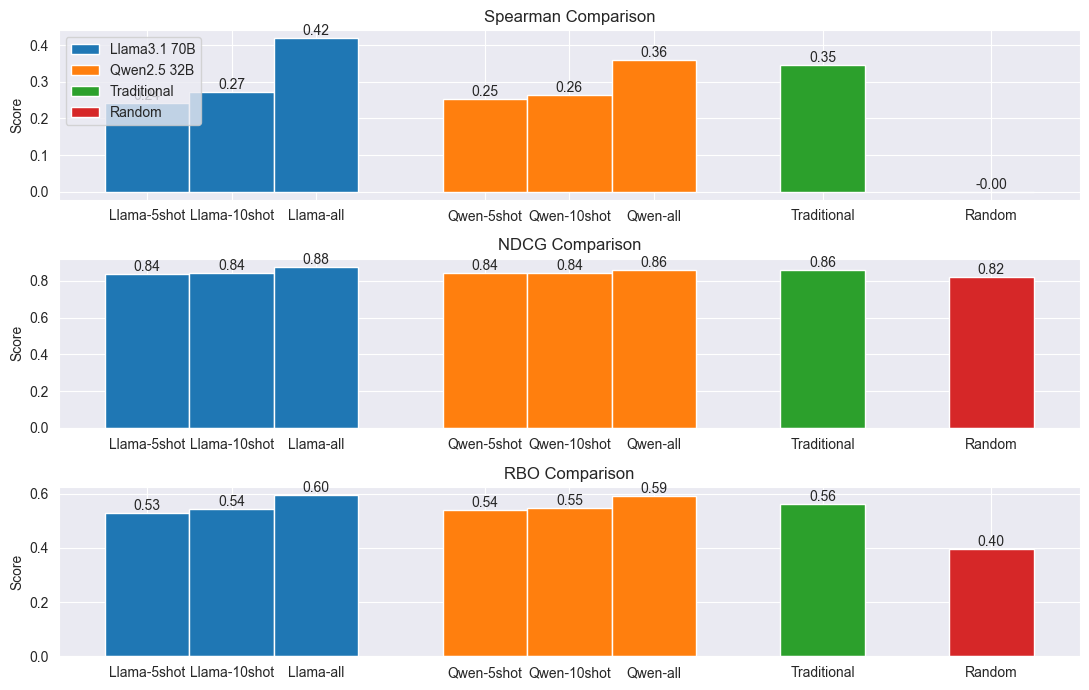

In [234]:
import matplotlib.pyplot as plt

models = [x.split('/')[1].split('.')[0] for x in csv_files]
models.append('Random')

data = {
    'models': models,
    'spearmans': spearmans,
    'ndcgs': ndcgs,
    'rbos': rbos
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df['models'] = df['models'].apply(lambda x: x.replace('_rp', '').strip())
df.rename(columns={'spearmans': 'Spearman', 'ndcgs': 'NDCG', 'rbos': 'RBO'}, inplace=True)
df.set_index('models', inplace=True)
# Set 'run_name' as the index

# Plot settings
metrics = ['Spearman', 'NDCG', 'RBO']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for the base and llama8

# Create a plot for each metric
fig, axs = plt.subplots(3, figsize=(11, 7))

for i, metric in enumerate(metrics):
    ax = axs[i]
    base_values = df.loc[['llama70b', 'llama70b_10', 'llama70b_all'], metric].values
    llama8_values = df.loc[['qwen', 'qwen_10', 'qwen_all'], metric].values
    trad_values = df.loc[['trad_user_ratings'], metric].values
    rand_values = df.loc[['Random'], metric].values

    # Bar positions
    bar_width = 0.25
    base_positions = [0, bar_width, 2*bar_width]
    llama8_positions = [1, 1+bar_width, 1+2*bar_width]
    trad_pos = [2]
    rand_pos = [2 + 2*bar_width]
    # llama8_positions = [1, 3]

    # Plot bars
    all_bars = []
    all_bars.append(ax.bar(base_positions, base_values, color=colors[0], width=bar_width, label='Llama3.1 70B'))
    all_bars.append(ax.bar(llama8_positions, llama8_values, color=colors[1], width=bar_width, label='Qwen2.5 32B'))
    all_bars.append(ax.bar(trad_pos, trad_values, color=colors[2], width=bar_width, label='Traditional'))
    all_bars.append(ax.bar(rand_pos, rand_values, color=colors[3], width=bar_width, label='Random'))

    for bars in all_bars:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    # Set x-ticks and labels
    ax.set_xticks(base_positions+llama8_positions+trad_pos+rand_pos)
    ax.set_xticklabels(['Llama-5shot', 'Llama-10shot', 'Llama-all'] + ['Qwen-5shot', 'Qwen-10shot', 'Qwen-all'] + ['Traditional'] + ['Random'])

    # Set title and labels
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel('Score')
    if i == 0:
        ax.legend(loc='upper left')
    # ax.legend()

# Adjust layout
plt.tight_layout()
plt.savefig('all_aligned.png')
plt.show()

In [217]:
# import matplotlib.pyplot as plt
#
# # Bar chart for spear and ndcg
#
# n_models = len(models)
#
# index = np.arange(n_models)
# bar_width = 0.2
#
# plt.figure(figsize=[8,4])
#
# plt.bar(index, spearmans, bar_width, label='Spearman')
# plt.bar(index + bar_width, ndcgs, bar_width, label='NDCG')
# plt.bar(index + bar_width + bar_width, rbos, bar_width, label='rbo')
# plt.xlabel('Model')
# plt.ylabel('Error Metric')
# plt.title('Error Metrics by Model')
# plt.xticks(index + bar_width / 2, models)
# plt.legend()
# plt.show()

Testing

In [218]:
# def get_ranked_indices(lst, reference_list):
#     return [reference_list.index(item) for item in lst]

In [219]:
df_10 = pd.read_csv('llm_output_processed/llama70b_rp_10.csv')
len(df_10)

6100

In [220]:
df2 = pd.read_csv('orig_data/all_ratings.csv')

df_all = pd.read_csv('llm_output_processed/llama70b_rp_all.csv')
merged = df2.merge(df_all, on=['userId', 'title'], how='inner')
merged_df = group_and_sort(merged)
merged_df['rbo'] = merged_df.apply(lambda x: rbo(x.pred_list, x.true_list), axis=1)
merged_df['ranked_indices'] = merged_df.apply(lambda x: get_ranked_indices(x.pred_list, x.true_list), axis=1)

In [221]:
df2

,userId,rating,title
0,1,4.0,Toy Story (1995)
1,1,4.0,Grumpier Old Men (1995)
2,1,4.0,Heat (1995)
3,1,5.0,Seven (a.k.a. Se7en) (1995)
4,1,5.0,"Usual Suspects, The (1995)"
...,...,...,...
100831,610,4.0,Split (2017)
100832,610,5.0,John Wick: Chapter Two (2017)
100833,610,5.0,Get Out (2017)
100834,610,5.0,Logan (2017)


In [222]:
df_all

,userId,title,predicted_rating
0,1,Tommy Boy (1995),5.0
1,2,"Dark Knight, The (2008)",4.0
2,3,Field of Dreams (1989),4.0
3,4,"Philadelphia Story, The (1940)",4.0
4,5,"Secret Garden, The (1993)",4.0
...,...,...,...
6085,606,Cape Fear (1991),4.0
6086,607,"Silence of the Lambs, The (1991)",5.0
6087,608,WarGames (1983),4.0
6088,609,Eraser (1996),3.0


In [223]:
merged_df = merged_df[merged_df['ranked_indices'].apply(len) > 3]

In [224]:
merged_df

,userId,pred_dict,true_dict,pred_list,true_list,rbo,ranked_indices
0,1,"{'Tommy Boy (1995)': 5.0, 'Mask, The (1994)': ...","{'Tommy Boy (1995)': 5.0, 'Mask, The (1994)': ...","[Tommy Boy (1995), Wizard of Oz, The (1939), D...","[Tommy Boy (1995), Wizard of Oz, The (1939), D...",0.870873,"[0, 1, 2, 3, 6, 4, 7, 8, 9, 5]"
1,2,"{'Tommy Boy (1995)': 4.0, 'Dark Knight, The (2...","{'Tommy Boy (1995)': 4.0, 'Dark Knight, The (2...",[The Jinx: The Life and Deaths of Robert Durst...,"[Warrior (2011), Mad Max: Fury Road (2015), Th...",0.355357,"[2, 6, 7, 5, 3, 4, 0, 1]"
2,3,"{'Field of Dreams (1989)': 4.0, 'Conan the Bar...","{'Field of Dreams (1989)': 0.5, 'Conan the Bar...",[Master of the Flying Guillotine (Du bi quan w...,"[Road Warrior, The (Mad Max 2) (1981), Hangar ...",0.420833,"[6, 0, 5, 3, 7, 4, 1, 2]"
3,4,"{'Ed Wood (1994)': 4.0, 'Dazed and Confused (1...","{'Ed Wood (1994)': 2.0, 'Dazed and Confused (1...","[Amadeus (1984), West Side Story (1961), Ed Wo...","[Philadelphia Story, The (1940), Waiting for G...",0.426190,"[3, 2, 7, 8, 0, 1, 9, 5, 4, 6]"
4,5,"{'Postman, The (Postino, Il) (1994)': 4.0, 'Br...","{'Postman, The (Postino, Il) (1994)': 5.0, 'Br...","[Braveheart (1995), Pinocchio (1940), Postman,...","[Postman, The (Postino, Il) (1994), Pinocchio ...",0.616327,"[2, 1, 0, 4, 6, 3, 5]"
...,...,...,...,...,...,...,...
604,606,"{'Godfather, The (1972)': 4.5, 'Cape Fear (199...","{'Godfather, The (1972)': 4.0, 'Cape Fear (199...","[Godfather, The (1972), Into the Wild (2007), ...","[Ice Age (2002), Godfather, The (1972), Into t...",0.656429,"[1, 2, 3, 4, 7, 0, 5, 6, 8, 9]"
605,607,"{'Silence of the Lambs, The (1991)': 5.0, 'Tru...","{'Silence of the Lambs, The (1991)': 5.0, 'Tru...","[Silence of the Lambs, The (1991), Poltergeist...","[Silence of the Lambs, The (1991), Con Air (19...",0.711111,"[0, 5, 4, 1, 2, 3, 6, 8, 9, 7]"
606,608,"{'Dragonheart (1996)': 3.5, 'L.A. Confidential...","{'Dragonheart (1996)': 3.5, 'L.A. Confidential...","[L.A. Confidential (1997), Suicide Kings (1997...","[Payback (1999), Suicide Kings (1997), Patch A...",0.569524,"[5, 1, 2, 0, 8, 7, 3, 6, 4, 9]"
607,609,"{'Toy Story (1995)': 3.0, 'Braveheart (1995)':...","{'Toy Story (1995)': 3.0, 'Braveheart (1995)':...","[Braveheart (1995), Pulp Fiction (1994), Shaws...","[Pulp Fiction (1994), Shawshank Redemption, Th...",0.593563,"[4, 0, 1, 3, 5, 6, 7, 8, 2]"


In [225]:
len(merged_df)

609

In [226]:
pr, tr = merged_df.head(1)[['pred_list', 'true_list']].values[0]
get_ranked_indices(pr, tr)
a = ndcg(pr,tr)
a

0.9908716117150927

In [227]:
np.log2(1)

0.0

In [228]:
a = ndcg(pr, tr)
a

0.9908716117150927

In [229]:
my_rbo = rbo(pr, tr)

print(f"rbo index: {my_rbo}")


rbo index: 0.8708730158730159


In [230]:
pr,tr = [9,8,7,6,5,4,3,2,1,0], [0,1,2,3,4,5,6,7,8,9]

In [231]:
get_ranked_indices(pr, tr)

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [232]:
ndcg(pr, tr)

0.5675670831396532